In [218]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from math import sqrt


import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [219]:
df = pd.read_excel('passenger.xlsx',header=None)

In [220]:
df.columns = ['year','passengers']

In [221]:
df.head()

,year,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [222]:
df.describe()

,passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [223]:
print('Time period start: {}\nTime period end: {}'.format(df.year.min(),df.year.max()))

Time period start: 1949-01
Time period end: 1960-12


In [224]:
df.shape

(144, 2)

In [225]:
df['year'] = pd.to_datetime(df['year'], format='%Y-%m')

In [226]:
y = df.set_index('year')

In [227]:
y.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='year', length=144, freq=None)

In [228]:
y.isnull().sum()

passengers    0
dtype: int64

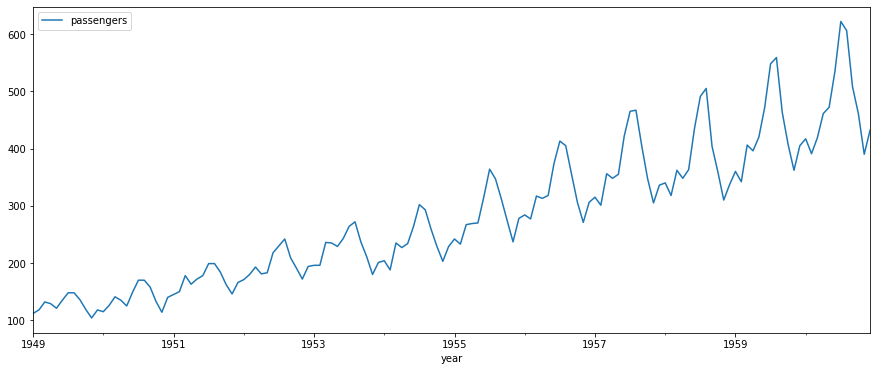

In [229]:
y.plot(figsize=(15, 6))
plt.show()

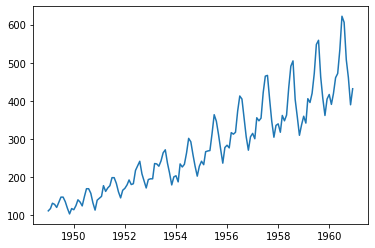

In [230]:
plt.plot(y)

In [231]:
from statsmodels.tsa.stattools import adfuller
#H0:IT IS NON STATIONARY
#H1:IT IS  STATIONARY

#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(y.passengers)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [232]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

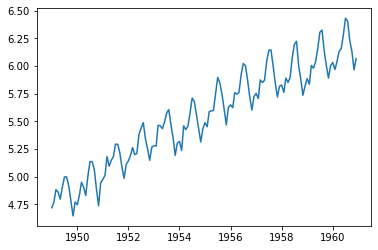

In [233]:
ts_log = np.log(y)  # USE LOG SCALE
plt.plot(ts_log)

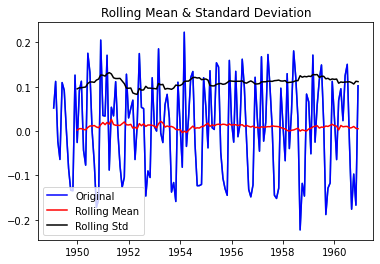

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [234]:
ts_log_diff = ts_log.passengers - ts_log.passengers.shift(1)  # DIFFERENCING OREDER =1 ======ARIMA 
plt.plot(ts_log_diff)
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)                           #stationary  series

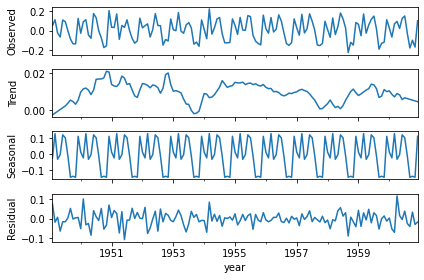

In [235]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts_log_diff, model='additive',extrapolate_trend='freq')
result.plot()
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Autocorrelation Function')

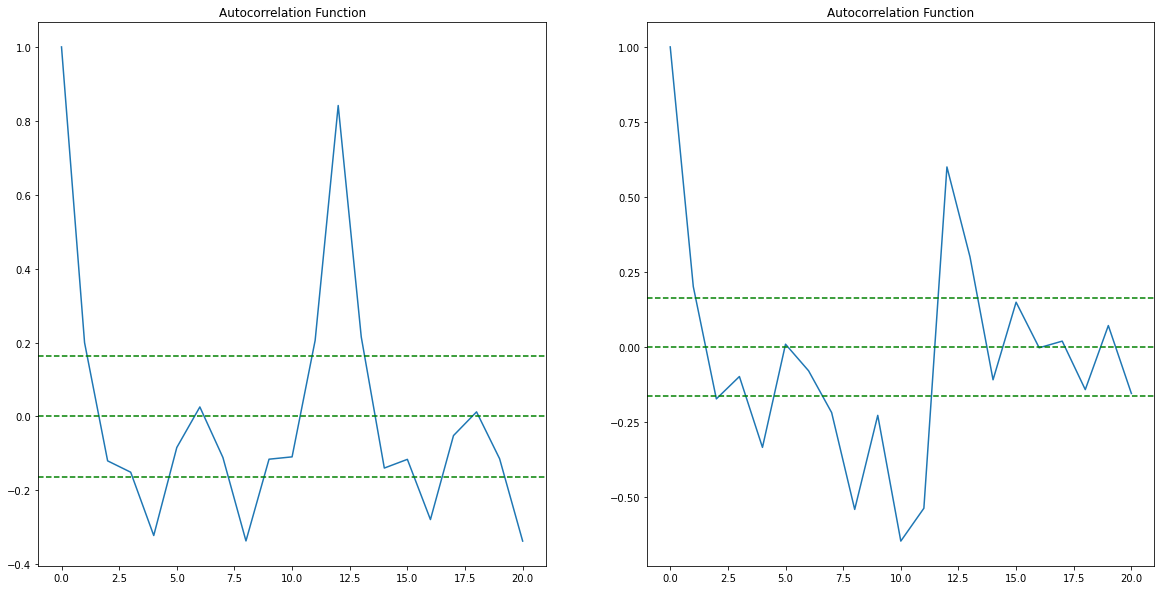

In [236]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf=acf(ts_log_diff, nlags=20)
lag_pacf=pacf(ts_log_diff, nlags=20, method='ols')

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

In [237]:
actuals = ts_log[130:-1]
actuals

,passengers
year,
1959-11-01,5.891644
1959-12-01,6.003887
1960-01-01,6.033086
1960-02-01,5.968708
1960-03-01,6.037871
1960-04-01,6.133398
1960-05-01,6.156979
1960-06-01,6.282267
1960-07-01,6.432940


In [238]:
ts_log.shape

(144, 1)

In [239]:
import itertools
p= d = q = range(0, 4)
pdq = itertools.product(p,d,q)
for parameters in pdq:
  
  try:
    model=ARIMA(ts_log_diff , order=parameters)  #log transformation
    results=model.fit(disp=1)
    ypredicted = results.predict(130,142) # end point included
    mae = mean_absolute_error(actuals, ypredicted)
    print('ARIMA{} - MAE:{}'.format(parameters, mae))
    print('ARMA{} - AIC:{}'.format(parameters, results.aic))
  except:
    continue
  # finally:
  #   print('ARIMA{} - MAE:{}'.format(parameters, mae))


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0) - MAE:6.119612727759461
ARMA(0, 0, 0) - AIC:-231.56489500229378
ARIMA(0, 0, 1) - MAE:6.122441290338879
ARMA(0, 0, 1) - AIC:-237.5073149855421
ARIMA(0, 0, 2) - MAE:6.119810687911937
ARMA(0, 0, 2) - AIC:-240.37895402025055
ARIMA(0, 0, 3) - MAE:6.094333110778394
ARMA(0, 0, 3) - AIC:-257.89027940829436
ARIMA(0, 1, 0) - MAE:6.128700006369024
ARMA(0, 1, 0) - AIC:-162.71343086452043
ARIMA(0, 1, 1) - MAE:6.121422801746446
ARMA(0, 1, 1) - AIC:-222.11663850898003
ARIMA(0, 1, 2) - MAE:6.122864325579412
ARMA(0, 1, 2) - AIC:-228.41156486219325


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

ARIMA(0, 1, 3) - MAE:6.121475903459108
ARMA(0, 1, 3) - AIC:-230.5918087246963
ARIMA(0, 2, 0) - MAE:6.127566259439228
ARMA(0, 2, 0) - AIC:-28.250106631018355
ARIMA(0, 2, 1) - MAE:6.123745816922125
ARMA(0, 2, 1) - AIC:-153.6086981826108
ARIMA(1, 0, 0) - MAE:6.121964232010957
ARMA(1, 0, 0) - AIC:-235.38589888263147


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

ARIMA(1, 0, 1) - MAE:6.122346802027993
ARMA(1, 0, 1) - AIC:-241.60771402612187
ARIMA(1, 0, 2) - MAE:6.102052480334785
ARMA(1, 0, 2) - AIC:-265.1896905950027


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 3) - MAE:6.101905932565658
ARMA(1, 0, 3) - AIC:-263.2333163543447
ARIMA(1, 1, 0) - MAE:6.128406847327157
ARMA(1, 1, 0) - AIC:-173.73789389552235
ARIMA(1, 2, 0) - MAE:6.121898150182872
ARMA(1, 2, 0) - AIC:-74.47800780617922


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

ARIMA(1, 2, 2) - MAE:6.119676488635509
ARMA(1, 2, 2) - AIC:-210.5776673033351


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 3) - MAE:6.119175078344865
ARMA(1, 2, 3) - AIC:-217.3665517171052
ARIMA(2, 0, 0) - MAE:6.120778206524918
ARMA(2, 0, 0) - AIC:-237.60463569752795


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1) - MAE:6.097481790697712
ARMA(2, 0, 1) - AIC:-270.1512196809504


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2) - MAE:6.111234766228683
ARMA(2, 0, 2) - AIC:-287.2808079215518


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 3) - MAE:6.11915825633604
ARMA(2, 0, 3) - AIC:-284.0721156831906
ARIMA(2, 1, 0) - MAE:6.1305822558971705
ARMA(2, 1, 0) - AIC:-184.75400041272212


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1) - MAE:6.1215794097940215
ARMA(2, 1, 1) - AIC:-228.1744939754209


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-pa

ARIMA(2, 1, 2) - MAE:6.123234022892425
ARMA(2, 1, 2) - AIC:-230.45449197311768
ARIMA(2, 2, 0) - MAE:6.1298214693915645
ARMA(2, 2, 0) - AIC:-114.14194293324573
ARIMA(2, 2, 1) - MAE:6.126353676212064
ARMA(2, 2, 1) - AIC:-174.41810839808608


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-pa

ARIMA(2, 2, 2) - MAE:6.125167744331588
ARMA(2, 2, 2) - AIC:-173.6584420382614
ARIMA(3, 0, 0) - MAE:6.119110882220611
ARMA(3, 0, 0) - AIC:-236.951784789785


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(3, 0, 1) - MAE:6.094978793179738
ARMA(3, 0, 1) - AIC:-270.08519037811715


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(3, 0, 2) - MAE:6.099148143197288
ARMA(3, 0, 2) - AIC:-270.15859907344185


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(3, 0, 3) - MAE:6.119723192110177
ARMA(3, 0, 3) - AIC:-289.4829058924285
ARIMA(3, 1, 0) - MAE:6.1296084406274
ARMA(3, 1, 0) - AIC:-183.72152283715832


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(3, 1, 1) - MAE:6.12010400547912
ARMA(3, 1, 1) - AIC:-227.33992067059341


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:6

ARIMA(3, 1, 2) - MAE:6.122809628798084
ARMA(3, 1, 2) - AIC:-228.75694269093208


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(3, 2, 0) - MAE:6.131731487555997
ARMA(3, 2, 0) - AIC:-115.28613554782129


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(3, 2, 1) - MAE:6.125843706180343
ARMA(3, 2, 1) - AIC:-173.220630090444


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:6

ARIMA(3, 2, 2) - MAE:6.125955871586712
ARMA(3, 2, 2) - AIC:-174.15822475241595


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(3, 2, 3) - MAE:6.11766906923324
ARMA(3, 2, 3) - AIC:-192.1088390701529


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


**We chose the mdoel which has less MAE and more AUC**
(3,0,3)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


plotting ARIMA model


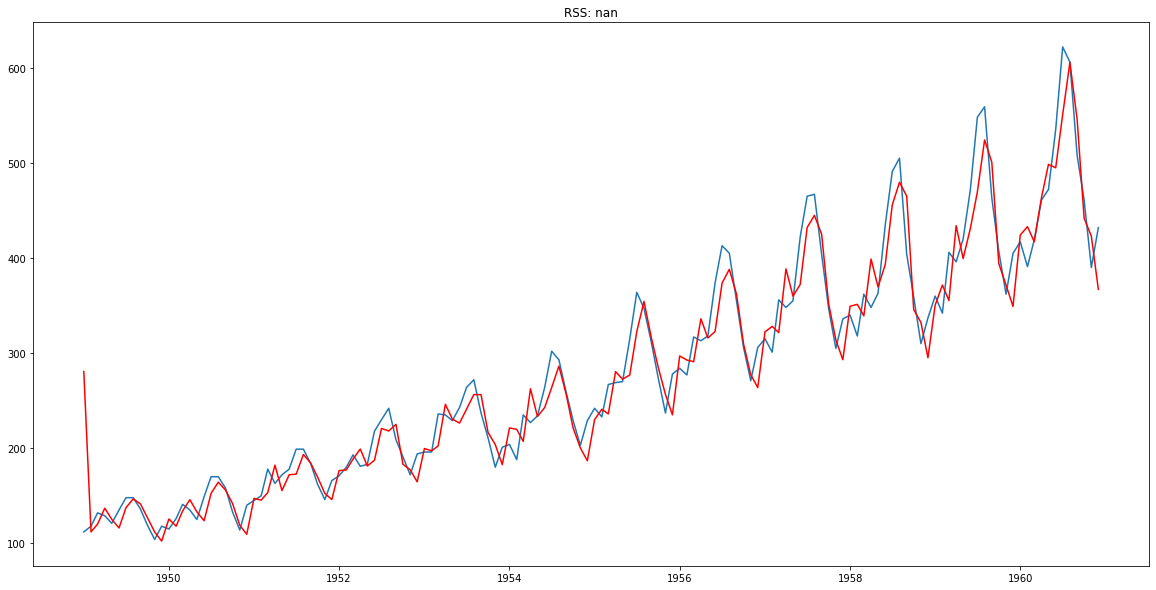

In [240]:
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize=(20,10))
model=ARIMA(y.passengers , order=(3,0,3))  #log transformation
results=model.fit(disp=1)
plt.plot(y.passengers)
plt.plot(results.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results.fittedvalues-ts_log_diff)**2))
print('plotting ARIMA model')

plotting AR model


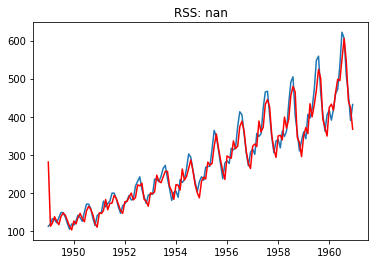

In [241]:
# model1=ARIMA(ts_log_diff , order=(3,0,3))#AR MODEL
# results1=model1.fit(disp=1)
plt.plot(y.passengers)
plt.plot(results.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results.fittedvalues-ts_log_diff)**2))
print('plotting AR model')

In [242]:
predictions=pd.Series(results.fittedvalues, copy=True)
print(predictions.head())

year
1949-01-01    280.639144
1949-02-01    112.000085
1949-03-01    120.185185
1949-04-01    136.931162
1949-05-01    125.204261
dtype: float64


In [243]:
predictions_cum_sum=predictions.cumsum()
print(predictions_cum_sum.head())

year
1949-01-01    280.639144
1949-02-01    392.639229
1949-03-01    512.824414
1949-04-01    649.755576
1949-05-01    774.959837
dtype: float64


In [244]:
predictions_log=pd.Series(ts_log.passengers.iloc[0], index=ts_log.index)
predictions_log=predictions_log.add(predictions_cum_sum,fill_value=0)
predictions_log.head()

year
1949-01-01    285.357643
1949-02-01    397.357728
1949-03-01    517.542913
1949-04-01    654.474074
1949-05-01    779.678336
dtype: float64

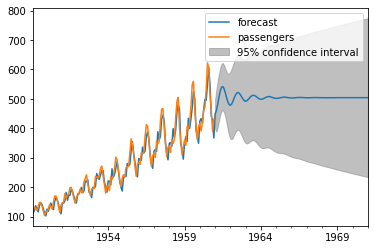

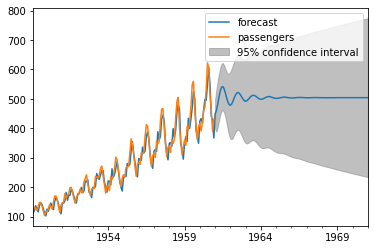

In [245]:
results.plot_predict(1,264)    #144 + 12*10         (12*12 )+(12*10)

In [246]:
# Sarima=sm.tsa.statespace.SARIMAX(df['passengers'],order=(1, 0, 3),seasonal_order=(1,0,2,8))
# Sarima_fit = Sarima.fit()
# ypredicted = Sarima_fit.predict(len(df), len(df)+12)  # end point included
# mae = mean_absolute_error(actuals, ypredicted)
# print('MAE: %f' % mae)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


MAE: 459.437236


In [247]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred)}, index=[0])
    
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [248]:
evaluate_forecast(actuals, ypredicted)    #actual          (y)    vs prediction(test)


,r2_score,mean_absolute_error,median_absolute_error,mse,msle,rmse
0,-7.980115e+06,459.437236,453.803821,212343.12802,17.465632,460.80704
